<a href="https://colab.research.google.com/github/Kishan459/NYC-Taxi-Trip-Time_prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#### importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import Dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/NYC Taxi Data (1).csv')

In [4]:
# checking the shape of data
df.shape

(1458644, 11)

In [5]:
# checking for null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

##### There are no nan/null record in dataset. so we don't have to impute any record.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### pickup_datetime,drpoff_datetime are object datatype we have to covert them into datetime format.

In [7]:
# converting timestamp to datatime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [9]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
# extracting hour,month,weekday,weekday_number from datatime feature
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday_num'] = df['pickup_datetime'].dt.dayofweek
df['weekday_name'] = df['pickup_datetime'].dt.day_name()

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_name
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday


In [12]:
!pip install haversine

In [13]:
import haversine as hs

In [14]:
# function for calculating distance
def calculate_distance(df):
  pickup = (df['pickup_latitude'],df['pickup_longitude'])
  drop = (df['dropoff_latitude'],df['dropoff_longitude'])
  return hs.haversine(pickup,drop)

In [15]:
# calculating distance 
df['distance'] = df.apply(lambda x : calculate_distance(x),axis=1)

In [16]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_name,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590


## Univeriate Analysis

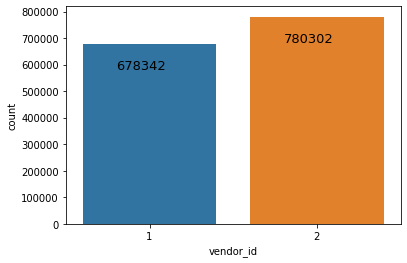

In [17]:
# finding which vender have large market share
ax = sns.countplot(df['vendor_id'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), va='top', color='black', size=13)
plt.show()

#### vender with id 2 has large market share than vender with id 1

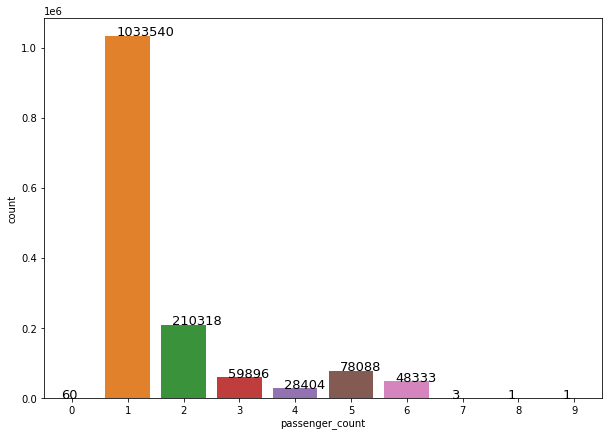

In [18]:
# finding frequency of trip according to number of passanger.
plt.figure(figsize=(10,7))
ax = sns.countplot(df['passenger_count'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.show()

#### most of the trip is taken by the single passanger and there are very fewer no. of trip is taken by more then 6 passengers and they might be outliers because fitting more then is not possible. 6 people is possible which contain 1 child and driver. 0 is outlier too.

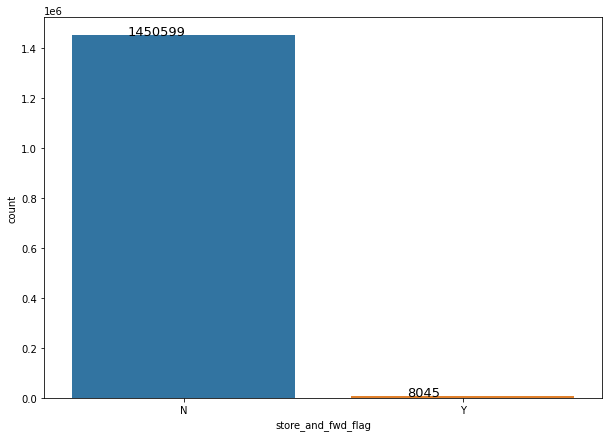

In [19]:
# finding frequency of trip according to trip record was held in vehicle or not 
plt.figure(figsize=(10,7))
ax = sns.countplot(df['store_and_fwd_flag'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.show()

In [20]:
# frequency of trip according to pick_hour
df['pickup_hour'].value_counts()

18    90600
19    90308
21    84185
20    84072
22    80492
17    76483
14    74292
12    71873
15    71811
13    71473
23    69785
11    68476
9     67663
8     67053
10    65437
16    64313
7     55600
0     53248
1     38571
6     33248
2     27972
3     20895
4     15792
5     15002
Name: pickup_hour, dtype: int64

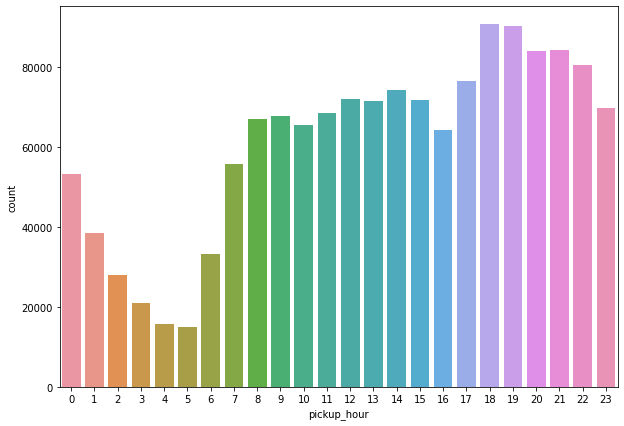

In [23]:
# visualization of frequency of trip according to pick_hour
plt.figure(figsize=(10,7))
sns.countplot(df['pickup_hour'])

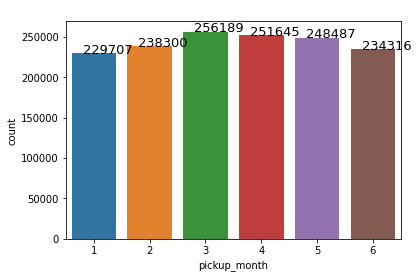

In [22]:
# visualization of frequency of trip according to month
ax = sns.countplot(df['pickup_month'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.show()

####dropoff_datetime has a extra month compared to pickup_datetime column with only 127 observatons when dropoff_datetime month is 7 , this is becuase people have taken ride at late night of last date of 6th month.